In [223]:
import os
import git
import sys

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(git_root)

from abm_vec.one_period_sim import run_sim
from abm_vec.initialization import get_bank_data

from scipy.optimize import minimize
from scipy.stats import kstest
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from abm_vec.essentials.util import get_git_root_directory
import numpy as np
import random
from scipy import stats
from scipy.stats import anderson_ksamp

import statsmodels.api as sm
from scipy.stats import pearsonr
import pickle
import time
import pandas as pd
from linearmodels import PanelOLS

In [2]:
bank_data = get_bank_data()

## Initial optimization considering different loss functions

In [15]:
# define loss functions
def mse_error(empirical, simulated):
    return np.average([(x-y)**2 for x,y in zip(empirical,simulated)])

def mae_error(empirical, simulated):
    return np.average([abs(x-y) for x,y in zip(empirical,simulated)])

def max_diff(empirical, simulated):
    return np.max([abs(x-y) for x,y in zip(empirical,simulated)])

def max_abs_diff(empirical, simulated):
    return np.max([abs((x-y)) for x,y in zip(empirical,simulated)])

In [4]:
def parameter_calibration(x, error_function):
    param = {'firm_lb1': x[0],'firm_lb2': x[1],'firm_ub1': x[2], 'firm_ub2': x[3], 
             'firm_alpha1': x[4], 'firm_alpha2': x[5], 'firm_rho': x[6], 'min_productivity': x[7]}
    results = run_sim(param, copy.deepcopy(bank_data), [1]) 
    empirical_le_ratio = results[0]['banks']['bank_loans'] / results[0]['banks']['bank_equity']
    simulated_le_ratio = results[1]['banks']['bank_loans'] / results[0]['banks']['bank_equity']
    return error_function(empirical_le_ratio, simulated_le_ratio)

def le_ratio(x, random_seeds):
    param = {'firm_lb1': x[0],'firm_lb2': x[1],'firm_ub1': x[2], 'firm_ub2': x[3], 
             'firm_alpha1': x[4], 'firm_alpha2': x[5], 'firm_rho': x[6], 'min_productivity': x[7]}
    results = run_sim(param, copy.deepcopy(bank_data), random_seeds)
    if len(random_seeds) > 1:
        empirical_le_ratio = [s[0]['banks']['bank_loans'] / s[0]['banks']['bank_equity'] for s in results]
        simulated_le_ratio = [s[1]['banks']['bank_loans'] / s[0]['banks']['bank_equity'] for s in results]
    else:
        empirical_le_ratio = [results[0]['banks']['bank_loans'] / results[0]['banks']['bank_equity']]
        simulated_le_ratio = [results[1]['banks']['bank_loans'] / results[0]['banks']['bank_equity']]
    return empirical_le_ratio, simulated_le_ratio

In [ ]:
loss_functions = {
    "mse": mse_error,
    "mae": mae_error,
    "max": max_diff
}

optimal_parameters = {
    "mse": None,
    "mae": None,
    "max": None
}

initial_guess = [10**6, 7500, 15 * 10 ** 7, 0.7 * 10 ** 6, 1.6, 1.7, 0.9, 150]
bounds = [(5 * 10 ** 5, 5 * 10 ** 6),
          (10 ** 3, 10**4),
          (5 * 10** 7, 30 * 10 ** 7),
          (5 * 10 ** 5, 10 ** 7),
          (0, 3),
          (0, 3),
          (0, 1) ,
          (100, 1000)]

for loss in optimal_parameters.keys():
    print(loss)
    min_fun = lambda x: parameter_calibration(x, loss_functions[loss])
    result = minimize(min_fun, initial_guess, method='Nelder-Mead', bounds=bounds)
    optimal_parameters[loss] = result.x

In [ ]:
# save parameters
with open(os.path.join(os.getcwd(), "calibrated_parameters.pickle"), 'wb') as handle:
    pickle.dump(optimal_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Comparing different loss functions

In [5]:
with open(os.path.join(os.getcwd(), "calibrated_parameters.pickle"), 'rb') as handle:
    optimal_parameters = pickle.load(handle)

In [6]:
# single linear regression with optimal parameters
ols_analysis = dict()
for loss in ['mse', 'mae', 'max']:
    print(loss)
    empirical_le_ratio, simulated_le_ratio = le_ratio(optimal_parameters[loss], [1])
    df = pd.DataFrame()
    df['empirical'] = empirical_le_ratio[0].tolist()
    df['simulated'] = simulated_le_ratio[0].tolist()
    ols_analysis[loss] = df

mse
mae
max


In [8]:
for loss in ['mse', 'mae', 'max']:
    df = ols_analysis[loss]
    df['constant'] = 1
    result = sm.OLS(df['empirical'].values, df[['simulated']].values, hasconst=False).fit(cov_type='HC3', use_t=True)
    print(result.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.913
Model:                            OLS   Adj. R-squared (uncentered):              0.912
Method:                 Least Squares   F-statistic:                              1122.
Date:                Sat, 13 Apr 2024   Prob (F-statistic):                    1.91e-48
Time:                        11:36:18   Log-Likelihood:                         -40.284
No. Observations:                  80   AIC:                                      82.57
Df Residuals:                      79   BIC:                                      84.95
Df Model:                           1                                                  
Covariance Type:                  HC3                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Multiple simulations with given optimal parameters

In [11]:
ols_analysis_multiple_loss = dict()
random_seeds = random.sample(range(1, 100000), 1000)
for loss in ['mse', 'mae', 'max']:
    print(loss)
    empirical_le_ratio, simulated_le_ratio = le_ratio(optimal_parameters[loss], random_seeds)
    ls = []
    for i in range(len(empirical_le_ratio)):
        ls.append((empirical_le_ratio[i].tolist(), simulated_le_ratio[i].tolist()))
    ols_analysis_multiple_loss[loss] = ls

mse
mae
max


In [12]:
# save multiple simulations
with open(os.path.join(os.getcwd(), "calibration_runs.pickle"), 'wb') as handle:
    pickle.dump(ols_analysis_multiple_loss, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# load multiple simulations
with open(os.path.join(os.getcwd(), "calibration_runs.pickle"), 'rb') as handle:
    ols_analysis_multiple_loss = pickle.load(handle)

In [23]:
# compute errors
labels = []
all_data_mae = []
all_data_mse = []
all_data_max_abs_diff = []
for loss in ['mse', 'mae', 'max']:
    data = ols_analysis_multiple_loss[loss]
    all_data_mse.append(np.array([mse_error(x[0],x[1]) for x in data]))
    all_data_mae.append(np.array([mae_error(x[0],x[1]) for x in data]))
    all_data_max_abs_diff.append(np.array([max_diff(x[0],x[1]) for x in data]))

labels = ['$L_{2}$', '$L_{1}$', '$L_{max}$']

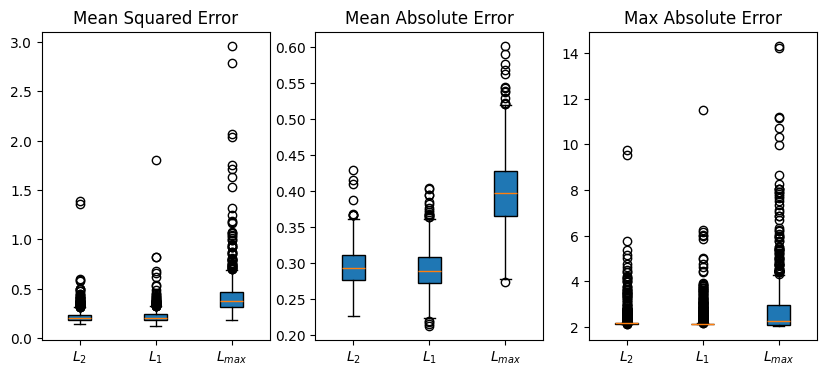

In [30]:
# Plot error bars
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(10,4))

bplot1 = ax1.boxplot(all_data_mse,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks

bplot2 = ax2.boxplot(all_data_mae,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks


bplot3 = ax3.boxplot(all_data_max_abs_diff,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks

ax1.set_title('Mean Squared Error')
ax2.set_title('Mean Absolute Error')
ax3.set_title('Max Absolute Error')
plt.savefig(os.path.join(git_root, 'plots_paper/error_bars.png'),bbox_inches='tight', dpi=400, edgecolor='white')
plt.show()

Best of are L1 and L2 norms. We choose the L2 as it seems to behave better in terms of Max Absolute Error

In [31]:
empirical_le_ratio, simulated_le_ratio = le_ratio(optimal_parameters['mse'], [1])

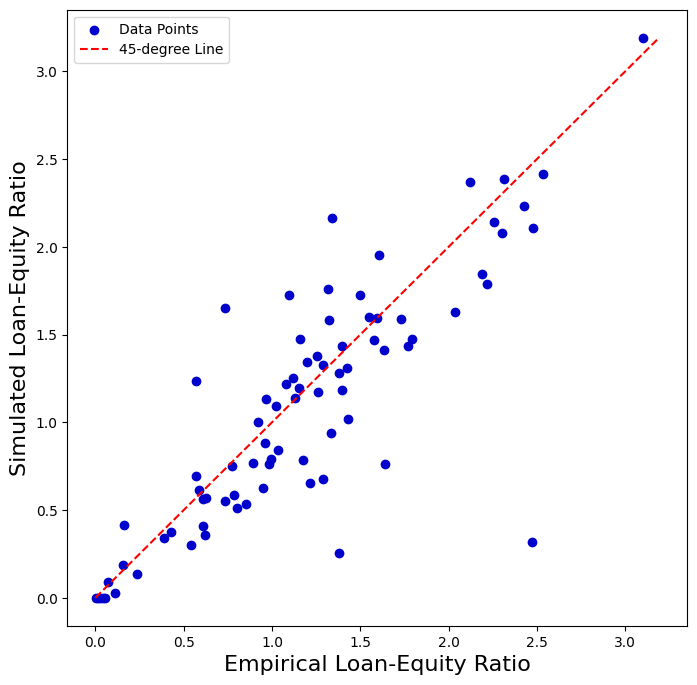

In [43]:
# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(empirical_le_ratio[0], simulated_le_ratio[0], color='mediumblue', label='Data Points')

# Plotting the 45-degree line for comparison
max_value = max(max(empirical_le_ratio[0]), max(simulated_le_ratio[0]))
plt.plot([0, max_value], [0, max_value], 'red',linestyle='dashed', label='45-degree Line')

# Adding labels and legend
plt.xlabel('Empirical Loan-Equity Ratio',fontsize=16)
plt.ylabel('Simulated Loan-Equity Ratio', fontsize=16)
plt.legend()
plt.savefig(os.path.join(git_root, 'plots_paper/scatter_plot_mse.png'),bbox_inches='tight', dpi=400, edgecolor='white')
plt.show()

## Errors for the mse

In [ ]:
optimal_x = optimal_parameters['mse']
random_seeds = random.sample(range(1, 1000000), 10000)
empirical_le_ratio, simulated_le_ratio = le_ratio(optimal_x, random_seeds)
ls = []
for i in range(len(empirical_le_ratio)):
    ls.append((empirical_le_ratio[i].tolist(), simulated_le_ratio[i].tolist()))

In [198]:
mae_errors = [mae_error(x[0],x[1]) for x in ls]
mse_errors = [mse_error(x[0],x[1]) for x in ls]
error_data = [mse_errors, mae_errors]
labels = ['$L_{2}$', '$L_{1}$']

In [203]:
results = []
for sublist in error_data:
    median = np.median(sublist)
    lower_percentile = np.percentile(sublist, 0.5)
    upper_percentile = np.percentile(sublist, 99.5)
    results.append((median, (lower_percentile, upper_percentile)))

In [205]:
medians = [result[0] for result in results]
conf_intervals = [result[1] for result in results]

In [211]:
conf_intervals

[(0.14305083058756554, 0.5454622904707415),
 (0.23127045445714667, 0.37673233583887805)]

Text(0, 0.5, 'Values')

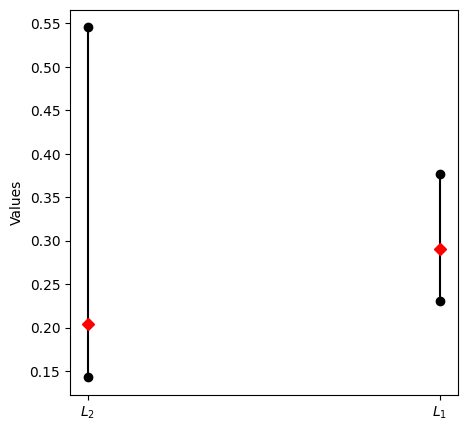

In [209]:
plt.figure(figsize=(5, 5))
for i, (median, conf_interval) in enumerate(zip(medians, conf_intervals)):
    plt.plot([i, i], conf_interval, color='black', linestyle='-', marker='o')  # Confidence interval lines
    plt.plot(i, median, color='red', marker='D')  # Median point

plt.xticks(range(len(labels)), labels)
plt.ylabel('Values')

# Price and consumption Optimization

In [45]:
optimal_x = optimal_parameters['mse']

In [46]:
def update_param(param, new):
    param_new = param.copy()
    param_new.update(new)
    return param_new

In [47]:
param = {'firm_lb1': optimal_x[0],
         'firm_lb2': optimal_x[1],
         'firm_ub1': optimal_x[2],
         'firm_ub2': optimal_x[3],
         'firm_alpha1': optimal_x[4],
         'firm_alpha2': optimal_x[5],
         'firm_rho': optimal_x[6],
         'min_productivity': optimal_x[7],
         'market_price': 600,
         "good_consumption": [0.98, 0.94],
         "good_consumption_std": [0.006, 0.006],
         "min_consumption": 0.9,
         "max_consumption": 1}

In [48]:
data = [run_sim(update_param(param, {'market_price': x}), copy.deepcopy(bank_data), [1]) for x in np.linspace(100, 1000, 100)]

In [49]:
min_prices_threshold = [res[1]['firms']['min_price_breach'] for res in data]
credit_demand = [len([x for x in res[1]["firms"]["firm_credit_demand"] if x>0]) for res in data]

Text(0.5, 1.0, 'Firm credit demand')

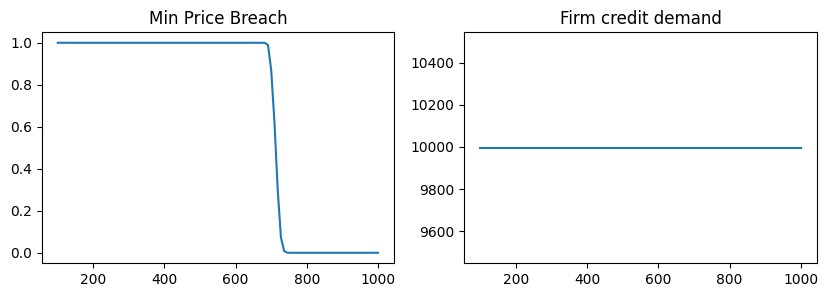

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(10,3))

ax1.plot(np.linspace(100, 1000, 100), min_prices_threshold)
ax2.plot(np.linspace(100, 1000, 100), credit_demand)

ax1.set_title('Min Price Breach')
ax2.set_title('Firm credit demand')

*Price should be from 700 onwards!!!*

Price is 690.909090909091


(array([  11.,   41.,  301., 1127., 2453., 2821., 2090.,  932.,  200.,
          24.]),
 array([662.6613516 , 667.9044844 , 673.1476172 , 678.39075   ,
        683.6338828 , 688.8770156 , 694.1201484 , 699.3632812 ,
        704.606414  , 709.8495468 , 715.09267959]),
 <BarContainer object of 10 artists>)

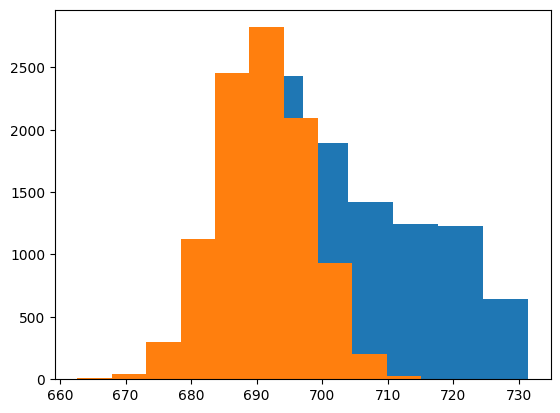

In [56]:
# price distribution 
res = data[65]
print(f'Price is {np.linspace(100, 1000, 100)[65]}')
plt.hist(res[1]['firms']['firm_price'])
plt.hist(res[0]['firms']['firm_price'])

# Consumption percentage

In [57]:
random_seeds = random.sample(range(1, 100000), 1000)

In [59]:
data = [run_sim(update_param(param, {'market_price': 700, 'good_consumption': [1, x], "min_consumption": x-0.1}), 
                copy.deepcopy(bank_data), 
                random_seeds) for x in np.linspace(0.1, 1, 50)]

In [155]:
def calculate_stats(sublist):
    median = np.median(sublist)
    lower_percentile = np.percentile(sublist, 0.5)
    upper_percentile = np.percentile(sublist, 99.5)
    return median, (lower_percentile, upper_percentile)

In [156]:
defaulting_firms = [[len(x[1]['firms']["defaulting_firms"]) for x in res] for res in data]
defaulting_banks = [[len(x[1]['banks']['defaulted_banks'])/80 for x in res] for res in data]

In [157]:
res_firms = [calculate_stats(sublist) for sublist in defaulting_firms]
res_banks = [calculate_stats(sublist) for sublist in defaulting_banks]

In [158]:
medians_f, conf_intervals_f = zip(*res_firms)
medians_b, conf_intervals_b = zip(*res_banks)

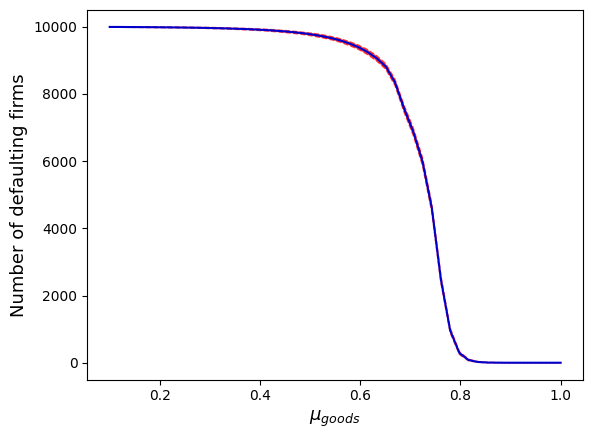

In [170]:
fig, ax = plt.subplots()
x = np.linspace(0.1, 1, 50)
ax.plot(x, medians_f, 'mediumblue', label='Medians')

ax.fill_between(x, np.array(conf_intervals_f)[:,0], np.array(conf_intervals_f)[:,1], color='red', alpha=0.7, linestyle='dashed', label='99% CI')
ax.set_ylabel('Number of defaulting firms', fontsize=13)
ax.set_xlabel('$\mu_{goods}$', fontsize=13)
#ax.set_title('Medians and Direct Confidence Intervals for Each List')
plt.savefig(os.path.join(git_root, 'plots_paper/fraction_defaulting_firms.png'),bbox_inches='tight', dpi=400, edgecolor='white')
plt.show()

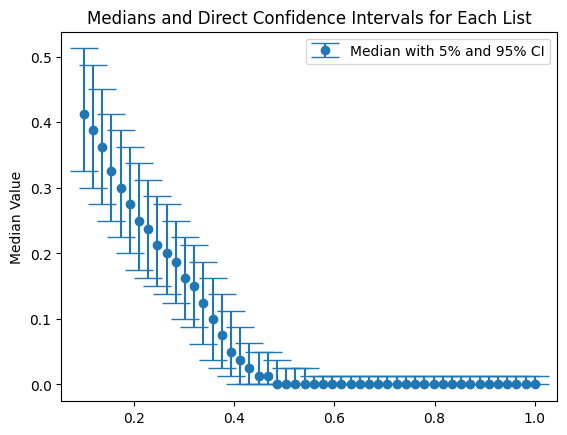

In [160]:
fig, ax = plt.subplots()
x = np.linspace(0.1, 1, 50)
ax.errorbar(x, medians_b, yerr=[np.array(medians_b)-np.array(conf_intervals_b)[:,0], np.array(conf_intervals_b)[:,1]-np.array(medians_b)], fmt='o', capsize=10, label='Median with 5% and 95% CI')
#ax.set_xticks(x)
#ax.set_xticklabels([f"List {i+1}" for i in x])
ax.set_ylabel('Median Value')
ax.set_title('Medians and Direct Confidence Intervals for Each List')
ax.legend()

plt.show()

In [212]:
# final data
d1 = run_sim(update_param(param, {'market_price': 700, 'good_consumption': [1, 0.82], "min_consumption": 0.71}), 
                copy.deepcopy(bank_data), 
                random.sample(range(1, 100000), 1000))

In [215]:
defaulting_firms = [len(res[1]['firms']["defaulting_firms"]) for res in d1]
defaulting_banks = [len(res[1]['banks']['defaulted_banks']) for res in d1]

(array([ 11.,  41.,  73., 167., 220., 203., 174.,  80.,  19.,  12.]),
 array([41. , 45.3, 49.6, 53.9, 58.2, 62.5, 66.8, 71.1, 75.4, 79.7, 84. ]),
 <BarContainer object of 10 artists>)

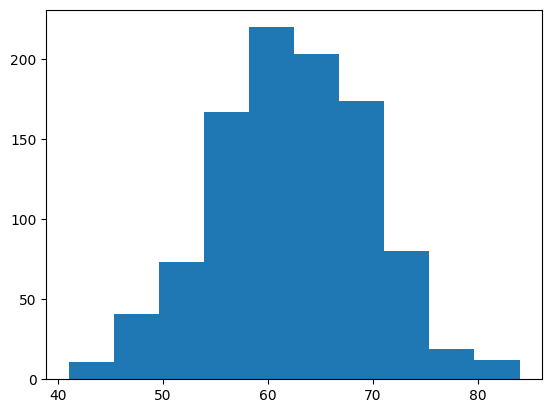

In [216]:
plt.hist(defaulting_firms)

(array([946.,   0.,   0.,   0.,   0.,  53.,   0.,   0.,   0.,   1.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

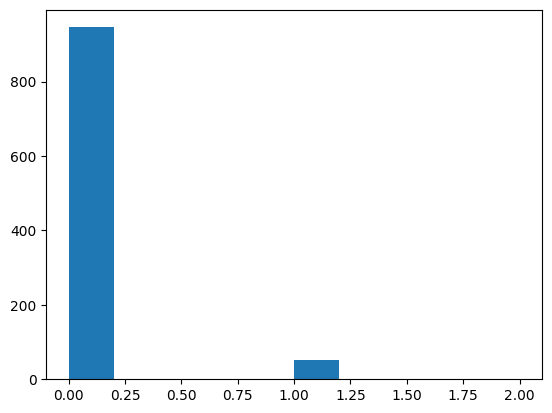

In [217]:
plt.hist(defaulting_banks)

In [222]:
update_param(param, {'market_price': 700, 'good_consumption': [1, 0.82], "min_consumption": 0.71})

{'firm_lb1': 1464093.454018507,
 'firm_lb2': 8455.032699087069,
 'firm_ub1': 104206211.12088007,
 'firm_ub2': 509267.6561693598,
 'firm_alpha1': 1.6833302927852407,
 'firm_alpha2': 2.217496529731626,
 'firm_rho': 0.9583571454384812,
 'min_productivity': 119.71131848674099,
 'market_price': 700,
 'good_consumption': [1, 0.82],
 'good_consumption_std': [0.006, 0.006],
 'min_consumption': 0.71,
 'max_consumption': 1}

In [224]:
1+1

2